In [15]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt

In [213]:
t_hor = 5010; #um
lambda_min = 7; #um
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [214]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [215]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [216]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c)) #cm
wavnums=list(map(lambda l :1/(l*1.0e-4),waves)) #cm
ret=list(map(lambda l :(retardance(l))*1.0e-4,lambda_c)) #cm

In [212]:
def model(theta,start,stop,D):
    delta = [2*np.pi*ret[start:stop][i]*wav[start:stop][i] for i in range(len(ret[start:stop]))]
    return D*np.cos(2*theta)*np.sin(delta) + D*np.sin(2*theta)*np.cos(delta)

10.487394957983193
expected retardance 0.008944157276944795
False Alarm Probability = 1.9162255501332993e-09
best frequency = 0.010750919965227477
-0.06752530389865742
dolp = 0.9995258313670776
aolp = -85.19085718370289


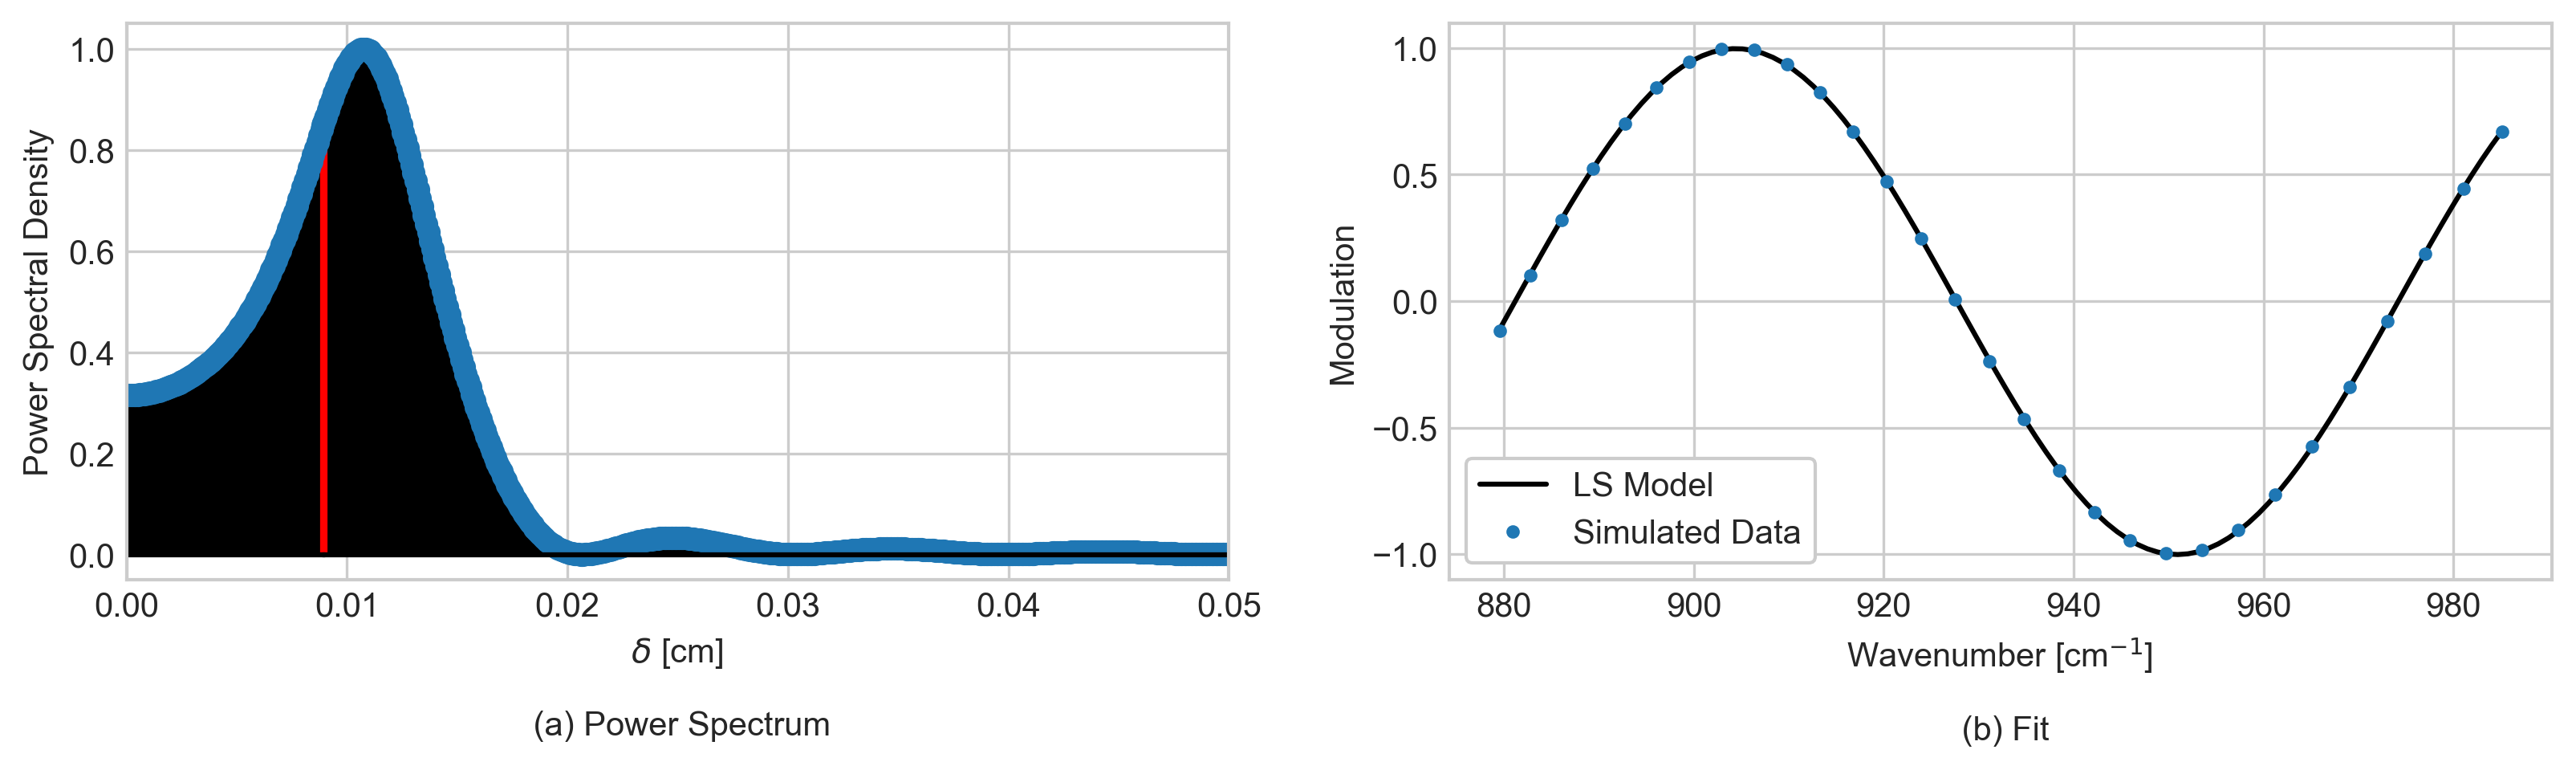

In [677]:
a = 45
j = 76

plt.style.use('seaborn-whitegrid')

print(lambda_c[j])
print('expected retardance ' + str(ret[j]))
start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
n = stop-start;

x = wav[start:stop] #select mod period
#data = calibration_mod[a] 
#data_err = calibration_modE[a] 

y = model(np.deg2rad(a),start,stop,1)

#y = data[start:stop]
#dy = data_err[start:stop]
#frequency = np.linspace(70,100,100)

ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+4],
                                              maximum_frequency=ret[j-4],samples_per_peak=100) #sampling in 1 period intervalsLombScargle(x, y,dy)
frequency_full,power_full = LombScargle(x, y).autopower(samples_per_peak=100) #calculate the full power spectrum



best_frequency = frequency_full[np.argmax(power_full)]
t_fit = np.linspace(x[-1],x[0],100)
y_fit = ls.model(t_fit, frequency_full[np.argmax(power_full)])

prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('False Alarm Probability = ' + str(prob))

[offset,q,u] = ls.model_parameters(best_frequency)
print("best frequency = " + str(best_frequency))
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
print(offset)
print('dolp = ' + str(dolp))
print('aolp = ' + str(np.rad2deg(aolp)))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency_full, power_full, 'k',basefmt = 'k')
axes[0].stem(frequency, power, 'r',basefmt = 'k')
axes[0].set_xlim(0,.05)
axes[0].set_xlabel('$\delta$ [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
#axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Simulated Data')
axes[1].plot(x,y,'.', label='Simulated Data')

legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [221]:
def LombFreq(j, data ):
    start = pixel1[j] #first pixel 
    stop  = pixel2[j] #last pixel 
    n = stop-start;

    x = wav[start:stop] #select mod period
    y = model(np.deg2rad(a),start,stop,1)


    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+4],
                                              maximum_frequency=ret[j-4],samples_per_peak=100)
    frequency_full,power_full = LombScargle(x, y).autopower(samples_per_peak=100) #calculate the full power spectrum

    best_frequency = frequency_full[np.argmax(power_full)]
    
    t_fit = np.linspace(x[-1],x[0],1000)
    y_fit = ls.model(t_fit, best_frequency) #plot on a finer grid
    
    amplitude = (y_fit.max()-y_fit.min())/2
    
    return(best_frequency, amplitude)

In [224]:
angles = np.arange(0,360,1)

In [225]:
efficiency = []

for j in range(0,90):

    powers = np.zeros(360)
    freqs = np.zeros(360)

    for a in range(360):
        data = model(np.deg2rad(a),start,stop,1)
        try:
            f , pwr = LombFreq(j, data)
            powers[a] = pwr
            freqs[a] = f
        except:
            pass

    x = np.linspace(0,2*np.pi,len(angles)) #select mod period
    y = powers
    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=.1,
                                                  maximum_frequency=2) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[0],x[-1],360)
    y_fit = ls.model(t_fit, best_frequency)
    efficiency.append(y_fit)

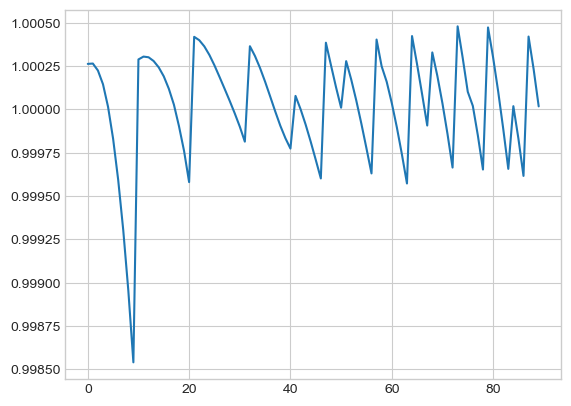

In [618]:
efficiency = np.array(efficiency)
#plt.imshow(efficiency,cmap = 'rainbow')
#plt.show()
eff_ang = t_fit

W = np.mean(efficiency,axis = 1)
plt.plot(W)

In [660]:
carrier = np.zeros(len(lambda_c))
for j in range(len(lambda_c)):
    freqs = np.zeros(360)
    for a in range(360):
        data = model(np.deg2rad(a),start,stop,1)
        try:
            f,p = LombFreq(j, data)
            freqs[a]= f
        except:
            freqs[a] = np.nan
    carrier[j] = np.median(freqs)

In [ ]:
def LombModel(a,j,thresh,W):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    x = wav[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(carrier[j])
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp_corr = aolp
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp,Q,U,prob,np.NAN])

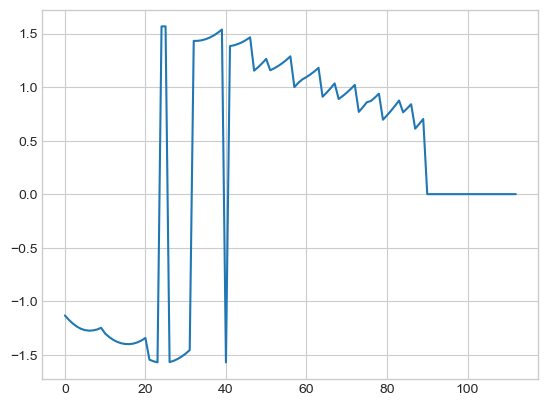

In [669]:
#get offset by finding the retrieved aolp given for an input aolp of zero for each wavelength

offset = []
results = np.zeros([len(lambda_c),360,6]) 
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,.1,efficiency)  
        except:
            w =1  
            
phase = results[:,0,1]
plt.plot(phase)

In [670]:
def LombModel(a,j,thresh,W):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    x = wav[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(carrier[j])
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp_corr = aolp - phase[j]
        eff = W[j,a]
        dolp_corr = dolp/eff
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q,dolp_corr,aolp_corr] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp_corr,aolp_corr,Q,U,prob,np.NAN])

In [671]:
aolp_cal1 = np.zeros([len(angles[:180])])
aolp_corr1 = np.zeros([len(angles[:180])])
dolp_cal1 = np.zeros([len(angles[:180])])
dolp_error1 = np.zeros([len(angles[:180])])
error1 = np.zeros([len(angles[:180])])

aolp_cal2 = np.zeros([len(angles[:180])])
aolp_corr2 = np.zeros([len(angles[:180])])
dolp_cal2 = np.zeros([len(angles[:180])])
dolp_error2 = np.zeros([len(angles[:180])])
error2 = np.zeros([len(angles[:180])])

j = 74 #10.4 um
for a in range(180):
    try:
        out = LombModel(a,j,.1,efficiency)  
        aolp_cal1[a] = np.rad2deg(out[1])
        if aolp_cal1[a] < 0:
            aolp_corr1[a] = aolp_cal1[a] + 180
        else:
            aolp_corr1[a] = aolp_cal1[a]
        dolp_cal1[a] = out[0]
        dolp_error1[a] = (out[0] - 1)
        error1[a] =  aolp_corr1[a]- angles[a] 
    except:
        pass

    
j = 45#9.2 um
for a in range(180):
    try:
        out = LombModel(a,j,.1,efficiency)  
        aolp_cal2[a] = np.rad2deg(out[1])
        if aolp_cal2[a] < 0:
            aolp_corr2[a] = aolp_cal2[a] + 180
        else:
            aolp_corr2[a] = aolp_cal2[a]
        dolp_cal2[a] = out[0]
        dolp_error2[a] = (out[0] - 1)
        error2[a] =  aolp_corr2[a]- angles[a] 
    except:
        pass


In [672]:
lambda_c[45] #at one wavelength

9.184873949579831

Text(0, 0.5, 'Retrieved AoLP')

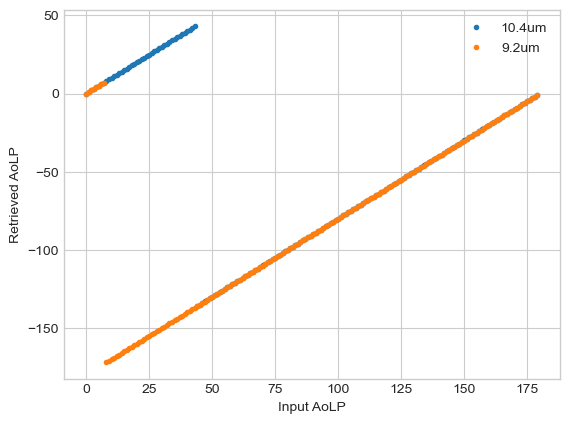

In [673]:
plt.plot(angles[:180],aolp_cal1,'.',label = '10.4um')
plt.plot(angles[:180],aolp_cal2,'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Retrieved AoLP')

Text(0, 0.5, 'Difference in Retrieved and Input AoLP')

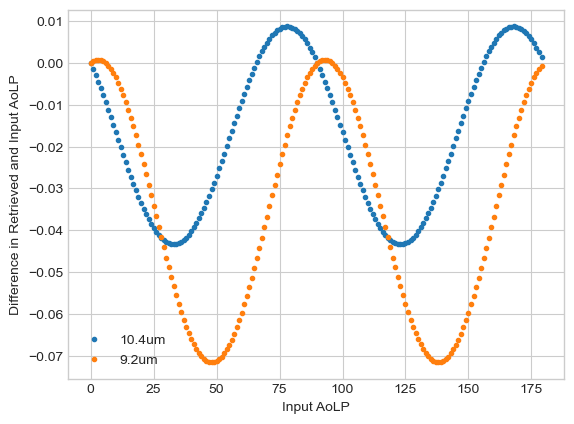

In [674]:
#some periodicity and wavelength dependance 

plt.plot(angles[:180],error1,'.',label = '10.4um')
plt.plot(angles[:180],error2,'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Difference in Retrieved and Input AoLP')

Text(0, 0.5, 'Retrieved DoLP')

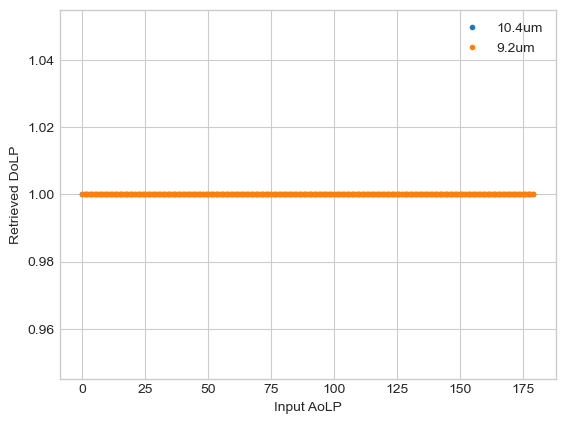

In [675]:
plt.plot(angles[:180],np.round(dolp_cal1,2),'.',label = '10.4um')
plt.plot(angles[:180],np.round(dolp_cal2,2),'.',label = '9.2um')
plt.legend()
plt.xlabel('Input AoLP')
plt.ylabel('Retrieved DoLP')